In [5]:
from util.get_data import get_features_and_targets, get_normalized_features_and_targets
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np

In [6]:
features, targets = get_features_and_targets()
features.head()

GENDER column transformed: [1 0]
EDUCATION_LEVEL column transformed: [2 1 3 4]
MARITAL_STATUS column transformed: [1 2 3]
CREDIT_LIMIT: 167 outliers capped.
AGE: 272 outliers capped.
SEPT_BILL: 2400 outliers capped.
AUG_BILL: 2395 outliers capped.
JULY_BILL: 2469 outliers capped.
JUNE_BILL: 2622 outliers capped.
MAY_BILL: 2725 outliers capped.
APRIL_BILL: 2693 outliers capped.
SEPT_PAYMENT: 2745 outliers capped.
AUG_PAYMENT: 2714 outliers capped.
JULY_PAYMENT: 2598 outliers capped.
JUNE_PAYMENT: 2994 outliers capped.
MAY_PAYMENT: 2945 outliers capped.
APRIL_PAYMENT: 2958 outliers capped.


,CREDIT_LIMIT,GENDER,EDUCATION_LEVEL,MARITAL_STATUS,AGE,SEPT_PAY_STATUS,AUG_PAY_STATUS,JULY_PAY_STATUS,JUNE_PAY_STATUS,MAY_PAY_STATUS,...,JULY_BILL,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT
1,20000,1,2,1,24.0,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0,689.0,0.0,0.0,0,0.0
2,120000,1,2,2,26.0,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0,1000.0,1000.0,1000.0,0,2000.0
3,90000,1,2,2,34.0,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518,1500.0,1000.0,1000.0,1000,5000.0
4,50000,1,2,1,37.0,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000,2019.0,1200.0,1100.0,1069,1000.0
5,50000,0,2,1,57.0,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000,11250.5,10000.0,9000.0,689,679.0


### K-means SMOTE to balance the data

In [7]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled =  pd.DataFrame(features_scaled, columns=features.columns, index=features.index)

features_train, features_test, targets_train, targets_test = train_test_split(features_scaled, targets, test_size=0.3, random_state=0)

kmeans_smote = KMeansSMOTE(
    random_state=0,
    k_neighbors=5,
    cluster_balance_threshold=0.1,
    n_jobs=-1
)

features_train_resampled, targets_train_resampled = kmeans_smote.fit_resample(features_train, targets_train)

/Users/alejandromarchini/miniconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## XGBoost and Feature Selection

### Recursive Feature Elimination using Logistic Regression

In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Perform Recursive Feature Elimination (RFE)
rfe_logistic = RFE(estimator=logistic_model, n_features_to_select=1, step=1)
fit_logistic = rfe_logistic.fit(features_train_resampled, targets_train_resampled['DEFAULT'].values.ravel())

# Create a DataFrame for feature rankings
all_features_ranking = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': fit_logistic.ranking_,
}).sort_values(by='Ranking')

# Display top-ranked features
print("Feature Ranking (Top 10):")
print(all_features_ranking.head(10))

Feature Ranking (Top 10):
            Feature  Ranking
5   SEPT_PAY_STATUS        1
7   JULY_PAY_STATUS        2
17     SEPT_PAYMENT        3
9    MAY_PAY_STATUS        4
11        SEPT_BILL        5
15         MAY_BILL        6
16       APRIL_BILL        7
21      MAY_PAYMENT        8
8   JUNE_PAY_STATUS        9
18      AUG_PAYMENT       10


### Baseline XGBoost with all features

In [9]:
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Helper function to run prediction and scores
def xgb_predict_and_score(model, x_test, y_test):
    pred = model.predict(x_test)
    score = accuracy_score(y_test, pred)
    print('Accuracy score: {}'.format(score))

    print("\nClassification Report:")
    print(classification_report(y_test, pred))

    print('ROC-AUC Score: {}'.format(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])))

    plot_importance(model, importance_type='gain')
    plt.title('Feature Importance by Gain')
    plt.show()

Accuracy score: 0.8107777777777778

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      7060
           1       0.60      0.38      0.46      1940

    accuracy                           0.81      9000
   macro avg       0.72      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000

ROC-AUC Score: 0.7530541237113402


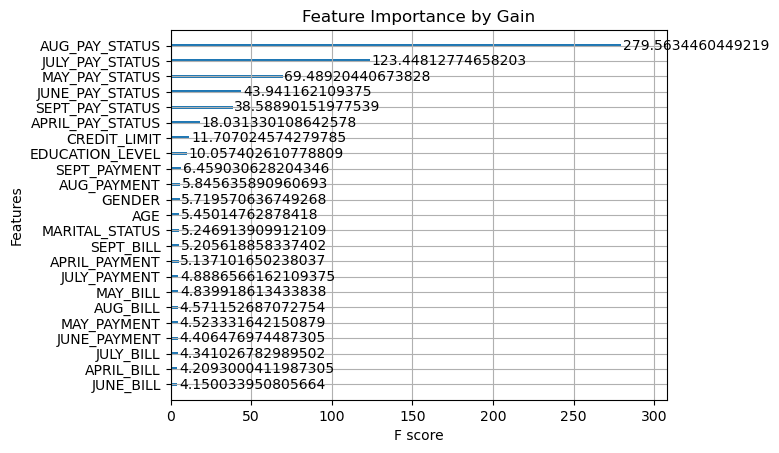

In [10]:
from xgboost import XGBClassifier

xgb_model_all_features = XGBClassifier(eval_metric='logloss')
xgb_model_all_features.fit(features_train_resampled, targets_train_resampled)

xgb_predict_and_score(xgb_model_all_features, features_test, targets_test)

### XGBoost with top 10 features by Gain

Accuracy score: 0.813

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.61      0.38      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.73      0.66      0.68      9000
weighted avg       0.79      0.81      0.80      9000

ROC-AUC Score: 0.7587560234806227


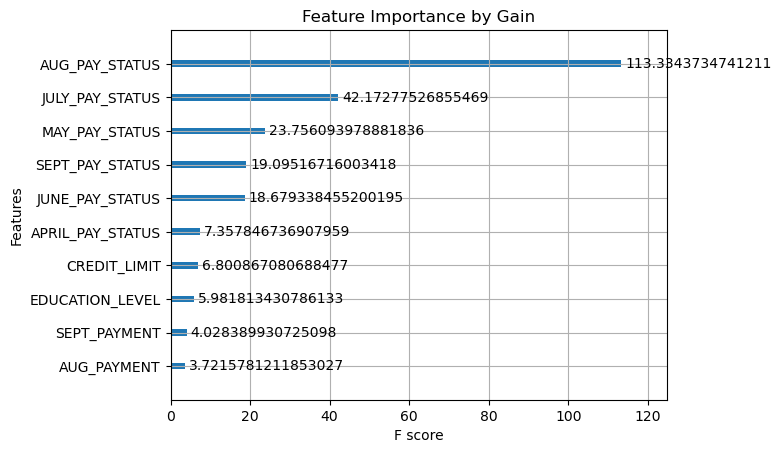

In [11]:
feature_importance = xgb_model_all_features.get_booster().get_score(importance_type='gain')
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Gain']).sort_values(by='Gain', ascending=False)
top_10_features = feature_importance_df.head(10).index.tolist()

xgb_model_top_10_features = XGBClassifier(eval_metric='logloss')
xgb_model_top_10_features.fit(features_train_resampled[top_10_features], targets_train_resampled)

xgb_predict_and_score(xgb_model_top_10_features, features_test[top_10_features], targets_test)

### XGBoost without demographic data

Accuracy score: 0.8124444444444444

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.60      0.38      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.72      0.66      0.68      9000
weighted avg       0.79      0.81      0.80      9000

ROC-AUC Score: 0.7544101369702988


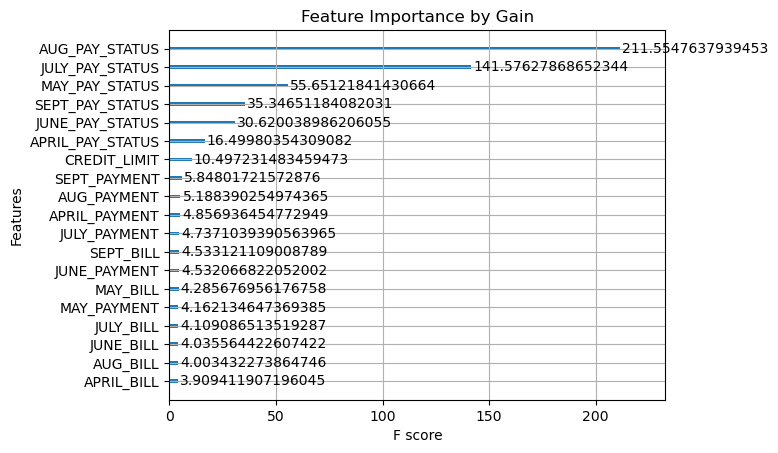

In [12]:
features_train_no_demographics = features_train_resampled.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)
features_test_no_demographics = features_test.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)

xgb_model_no_demographics = XGBClassifier(eval_metric='logloss')
xgb_model_no_demographics.fit(features_train_no_demographics, targets_train_resampled)

xgb_predict_and_score(xgb_model_no_demographics, features_test_no_demographics, targets_test)

### Use only 3 most recent months in features

Accuracy score: 0.8165555555555556

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.62      0.40      0.48      1940

    accuracy                           0.82      9000
   macro avg       0.73      0.66      0.69      9000
weighted avg       0.80      0.82      0.80      9000

ROC-AUC Score: 0.7578848821588154


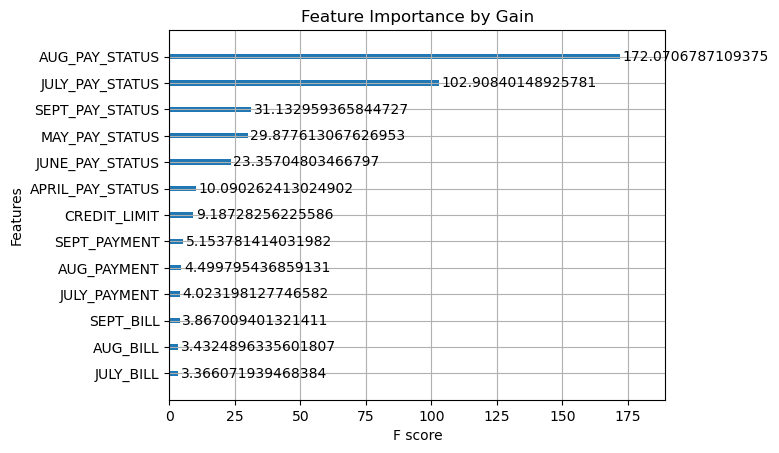

In [13]:
features_train_no_demo_most_recent = features_train_no_demographics.drop(['APRIL_BILL', 'APRIL_PAYMENT', 'MAY_BILL', 'MAY_PAYMENT', 'JUNE_BILL', 'JUNE_PAYMENT'], axis=1)
features_test_no_demo_most_recent = features_test_no_demographics.drop(['APRIL_BILL', 'APRIL_PAYMENT', 'MAY_BILL', 'MAY_PAYMENT', 'JUNE_BILL', 'JUNE_PAYMENT'], axis=1)

xgb_model_no_demo_most_recent = XGBClassifier(eval_metric='logloss')
xgb_model_no_demo_most_recent.fit(features_train_no_demo_most_recent, targets_train_resampled)

xgb_predict_and_score(xgb_model_no_demo_most_recent, features_test_no_demo_most_recent, targets_test)

## SHAP (SHapley Additive exPlanations)

In [14]:
# Helper function for SHAP summary and rankings
def shap_summary(model, features):
    # Create a SHAP explainer
    explainer = shap.Explainer(model, features)

    # Compute SHAP values
    shap_values = explainer(features)

    # Combine SHAP feature importance dataframe
    shap_importance = pd.DataFrame({
        'Feature': features.columns,
        'SHAP Importance': np.abs(shap_values.values).mean(axis=0),
    }).sort_values(by='SHAP Importance', ascending=False)

    # Display the shap importance
    print(shap_importance)

    # SHAP summary plot
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, features)
    
    return shap_importance

### Feature Importance via SHAP Summary Plot

 99%|===================| 32356/32612 [01:19<00:00]        

             Feature  SHAP Importance
5    SEPT_PAY_STATUS         1.045139
0       CREDIT_LIMIT         0.573700
6     AUG_PAY_STATUS         0.360892
4                AGE         0.309603
7    JULY_PAY_STATUS         0.285275
2    EDUCATION_LEVEL         0.282116
10  APRIL_PAY_STATUS         0.275695
9     MAY_PAY_STATUS         0.216128
17      SEPT_PAYMENT         0.193319
11         SEPT_BILL         0.184228
8    JUNE_PAY_STATUS         0.173702
22     APRIL_PAYMENT         0.171784
19      JULY_PAYMENT         0.145939
18       AUG_PAYMENT         0.144437
21       MAY_PAYMENT         0.141010
14         JUNE_BILL         0.138471
13         JULY_BILL         0.137398
16        APRIL_BILL         0.108364
15          MAY_BILL         0.102862
12          AUG_BILL         0.098129
1             GENDER         0.096178
20      JUNE_PAYMENT         0.094695
3     MARITAL_STATUS         0.080735


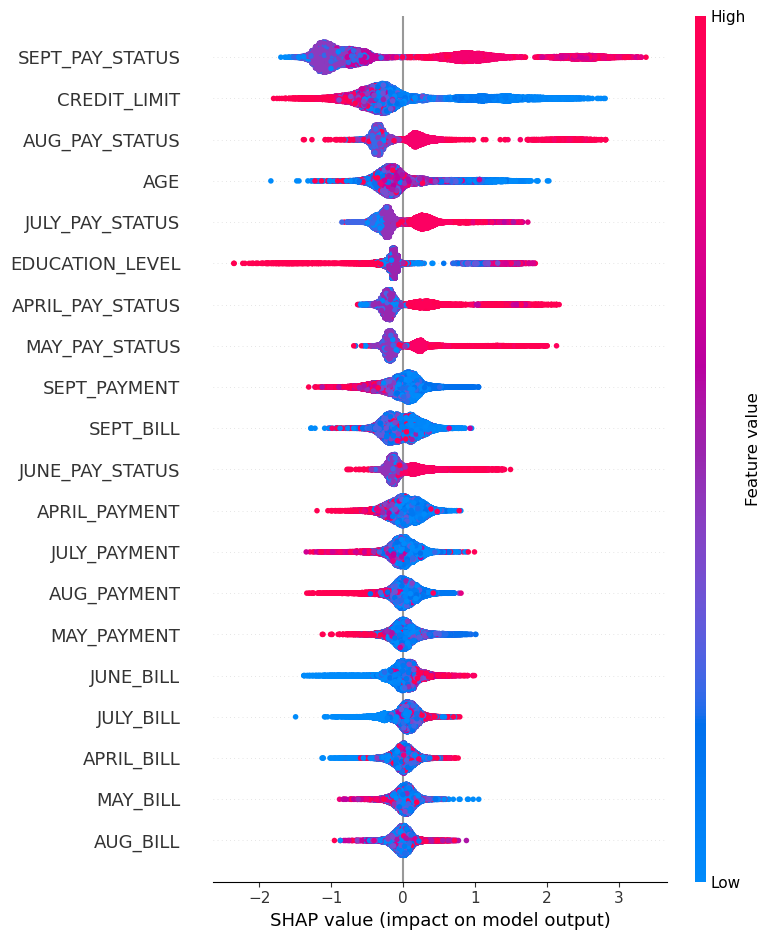

In [15]:
#xgboost with all features 
all_features_shap = shap_summary(xgb_model_all_features, features_train_resampled)

100%|===================| 32458/32612 [01:21<00:00]        

             Feature  SHAP Importance
1    SEPT_PAY_STATUS         1.045475
0       CREDIT_LIMIT         0.763267
2     AUG_PAY_STATUS         0.397090
3    JULY_PAY_STATUS         0.340952
6   APRIL_PAY_STATUS         0.331678
4    JUNE_PAY_STATUS         0.243107
13      SEPT_PAYMENT         0.235583
7          SEPT_BILL         0.214166
5     MAY_PAY_STATUS         0.199327
18     APRIL_PAYMENT         0.191201
14       AUG_PAYMENT         0.169733
12        APRIL_BILL         0.164033
17       MAY_PAYMENT         0.161610
8           AUG_BILL         0.159099
15      JULY_PAYMENT         0.143250
9          JULY_BILL         0.134132
11          MAY_BILL         0.133310
10         JUNE_BILL         0.124392
16      JUNE_PAYMENT         0.120192


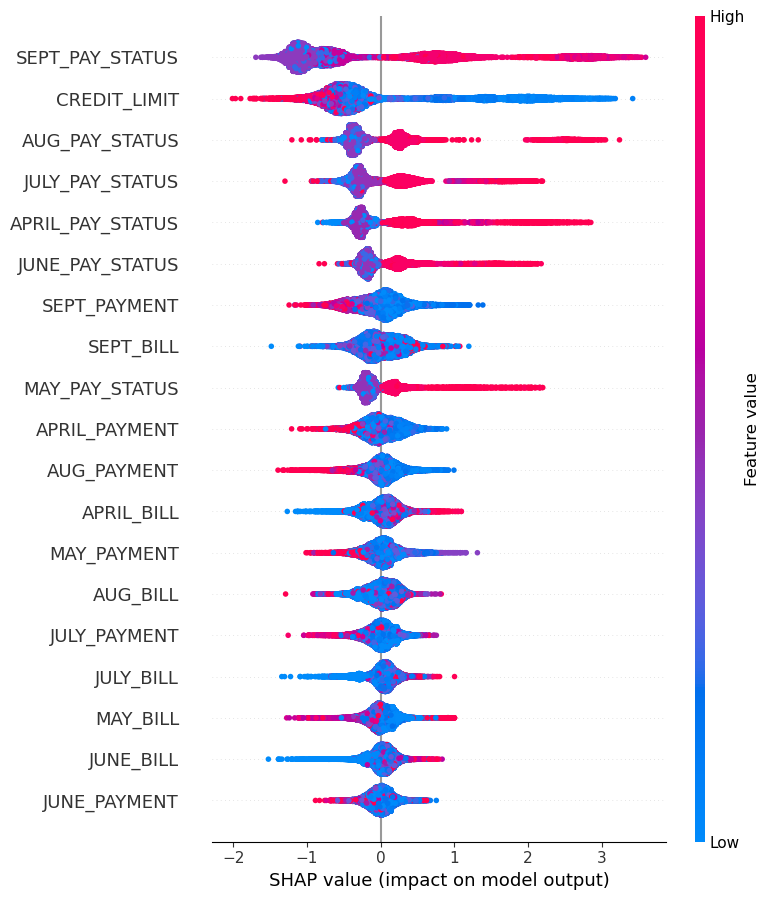

In [16]:
#xgboost with no demographics 
no_demo_features_shap = shap_summary(xgb_model_no_demographics, features_train_no_demographics)

### SHAP Interaction Values

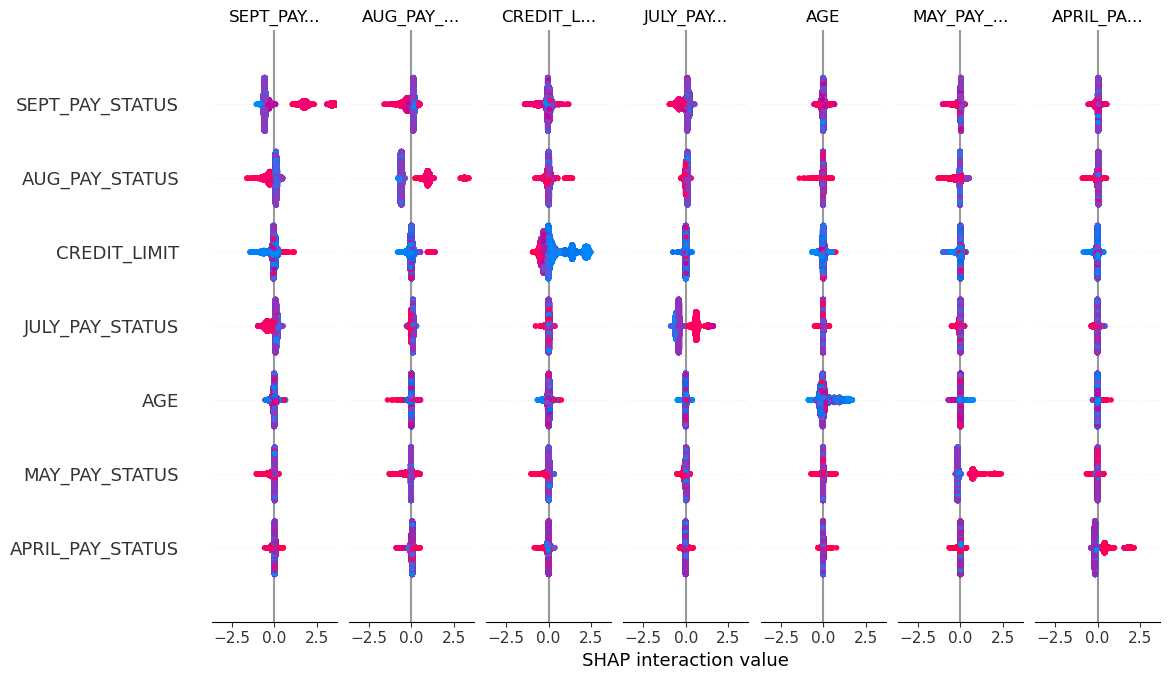

In [19]:
explainer = shap.TreeExplainer(xgb_model_all_features)
shap_interaction_values = explainer.shap_interaction_values(features_train_resampled)
shap.summary_plot(shap_interaction_values, features_train_resampled, plot_type="dot")

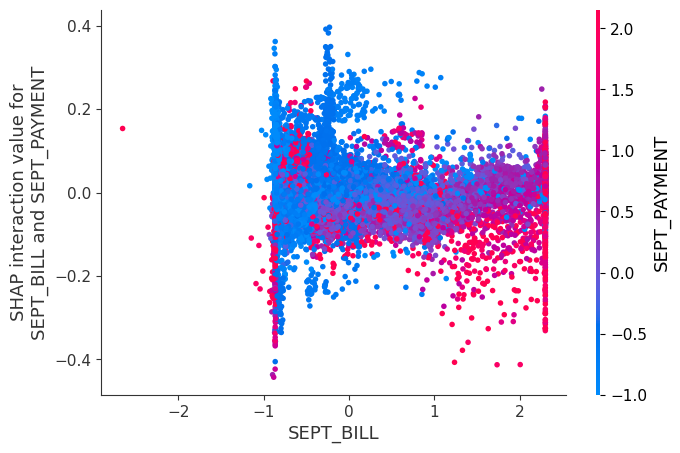

In [20]:
shap.dependence_plot(('SEPT_BILL', 'SEPT_PAYMENT'), shap_interaction_values, features_train_resampled)


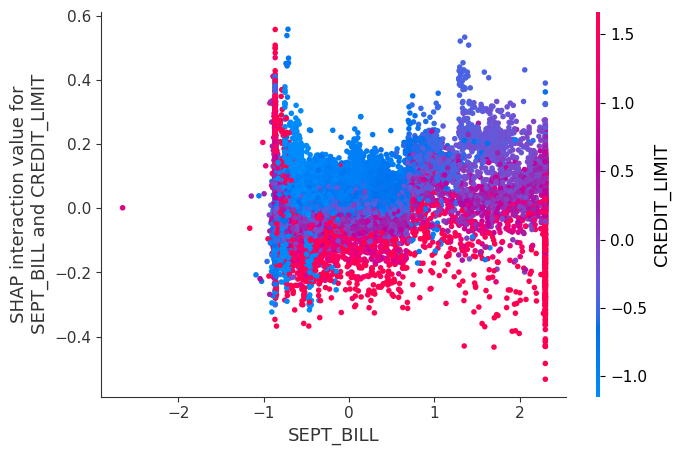

In [21]:
shap.dependence_plot(('SEPT_BILL', 'CREDIT_LIMIT'), shap_interaction_values, features_train_resampled)

### Create threshold for SHAP importance and model based on those

In [22]:
shap_threshold = 0.95
all_features_shap['cumulative_importance'] = all_features_shap['SHAP Importance'].cumsum() / all_features_shap['SHAP Importance'].sum()
filtered_features = all_features_shap[all_features_shap['cumulative_importance'] <= shap_threshold]
filtered_features

,Feature,SHAP Importance,cumulative_importance
5,SEPT_PAY_STATUS,1.045139,0.194996
0,CREDIT_LIMIT,0.573700,0.302033
6,AUG_PAY_STATUS,0.360892,0.369367
4,AGE,0.309603,0.427130
7,JULY_PAY_STATUS,0.285275,0.480355
2,EDUCATION_LEVEL,0.282116,0.532991
10,APRIL_PAY_STATUS,0.275695,0.584428
9,MAY_PAY_STATUS,0.216128,0.624752
17,SEPT_PAYMENT,0.193319,0.660821
11,SEPT_BILL,0.184228,0.695193


Accuracy score: 0.8135555555555556

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.61      0.39      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.73      0.66      0.68      9000
weighted avg       0.79      0.81      0.80      9000

ROC-AUC Score: 0.7570491516018808


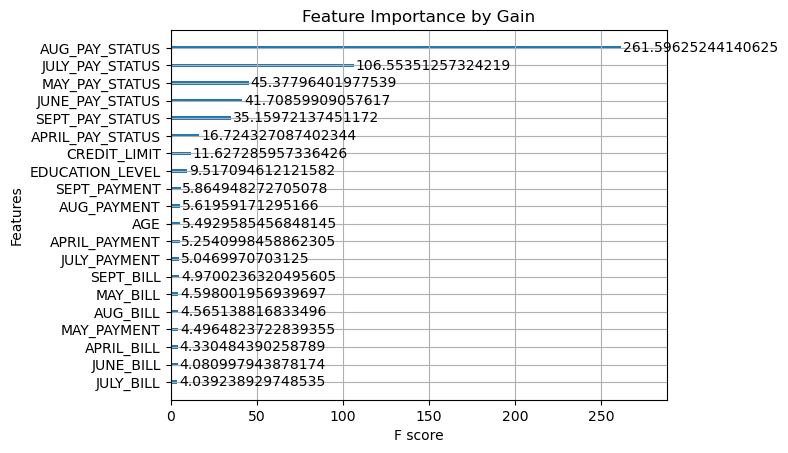

In [23]:
features_train_passing_shap_threshold = features_train_resampled[filtered_features['Feature'].tolist()]
features_test_passing_shap_threshold = features_test[filtered_features['Feature'].tolist()]

xgb_model_passing_shap_threshold = XGBClassifier(eval_metric='logloss')
xgb_model_passing_shap_threshold.fit(features_train_passing_shap_threshold, targets_train_resampled)

xgb_predict_and_score(xgb_model_passing_shap_threshold, features_test_passing_shap_threshold, targets_test)

### Model based on SHAP threshold no demographic data

In [24]:
no_demo_features_shap['cumulative_importance'] = no_demo_features_shap['SHAP Importance'].cumsum() / no_demo_features_shap['SHAP Importance'].sum()
no_demo_filtered_features = no_demo_features_shap[no_demo_features_shap['cumulative_importance'] <= shap_threshold]
no_demo_filtered_features

,Feature,SHAP Importance,cumulative_importance
1,SEPT_PAY_STATUS,1.045475,0.198322
0,CREDIT_LIMIT,0.763267,0.343111
2,AUG_PAY_STATUS,0.397090,0.418437
3,JULY_PAY_STATUS,0.340952,0.483114
6,APRIL_PAY_STATUS,0.331678,0.546032
4,JUNE_PAY_STATUS,0.243107,0.592149
13,SEPT_PAYMENT,0.235583,0.636838
7,SEPT_BILL,0.214166,0.677464
5,MAY_PAY_STATUS,0.199327,0.715276
18,APRIL_PAYMENT,0.191201,0.751546


Accuracy score: 0.8136666666666666

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.61      0.39      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.73      0.66      0.68      9000
weighted avg       0.79      0.81      0.80      9000

ROC-AUC Score: 0.7505602932157355


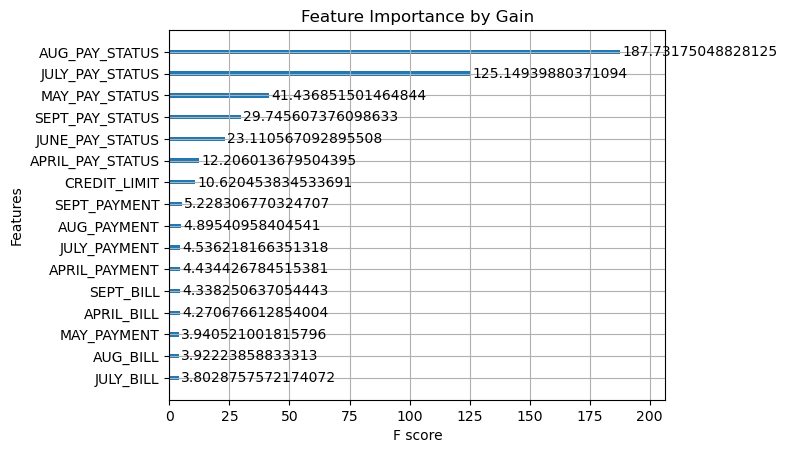

In [25]:
features_train_passing_shap_threshold_no_demo = features_train_resampled[no_demo_filtered_features['Feature'].tolist()]
features_test_passing_shap_threshold_no_demo = features_test[no_demo_filtered_features['Feature'].tolist()]

xgb_model_passing_shap_threshold_no_demo = XGBClassifier(eval_metric='logloss')
xgb_model_passing_shap_threshold_no_demo.fit(features_train_passing_shap_threshold_no_demo, targets_train_resampled)

xgb_predict_and_score(xgb_model_passing_shap_threshold_no_demo, features_test_passing_shap_threshold_no_demo, targets_test)

## Testing Derived Features

### Remaining Balance Feature

In [26]:
months = ['APRIL', 'MAY', 'JUNE', 'JULY', 'AUG', 'SEPT']

derived_features = features.copy()

for month in months:
    derived_features['{}_REMAINING_BALANCE'.format(month)] = derived_features['{}_BILL'.format(month)] - derived_features['{}_PAYMENT'.format(month)]

bill_columns_to_drop = derived_features.filter(regex='_BILL').columns
payment_columns_to_drop = derived_features.filter(regex='_PAYMENT').columns
derived_features.drop(columns=bill_columns_to_drop, inplace=True)
derived_features.drop(columns=payment_columns_to_drop, inplace=True)

scaler = StandardScaler()
derived_features_scaled = scaler.fit_transform(derived_features)
derived_features_scaled =  pd.DataFrame(derived_features_scaled, columns=derived_features.columns, index=derived_features.index)

derived_features_train, derived_features_test, targets_train, targets_test = train_test_split(derived_features_scaled, targets, test_size=0.3, random_state=0)

derived_features_train_resampled, targets_train_resampled = kmeans_smote.fit_resample(derived_features_train, targets_train)

/Users/alejandromarchini/miniconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### xgboost with derived remaining balance feature

Accuracy score: 0.8171111111111111

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7060
           1       0.62      0.38      0.47      1940

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000

ROC-AUC Score: 0.7603512236792149


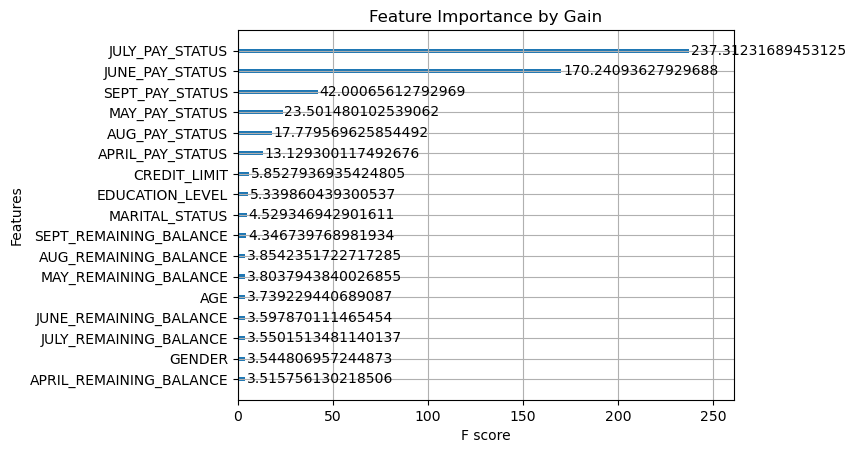

In [27]:
xgb_model_all_derived_features = XGBClassifier(eval_metric='logloss')
xgb_model_all_derived_features.fit(derived_features_train_resampled, targets_train_resampled)

xgb_predict_and_score(xgb_model_all_derived_features, derived_features_test, targets_test)

#### Remove demographics

Accuracy score: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7060
           1       0.63      0.39      0.48      1940

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.69      9000
weighted avg       0.80      0.82      0.80      9000

ROC-AUC Score: 0.7578092783505155


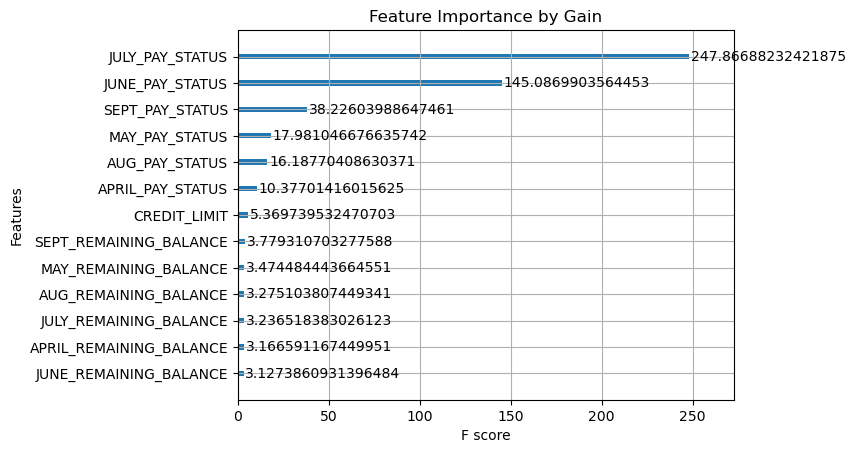

In [28]:
derived_features_train_resampled_no_demo = derived_features_train_resampled.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)
derived_features_test_no_demo = derived_features_test.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)

xgb_model_all_derived_features_no_demo = XGBClassifier(eval_metric='logloss')
xgb_model_all_derived_features_no_demo.fit(derived_features_train_resampled_no_demo, targets_train_resampled)

xgb_predict_and_score(xgb_model_all_derived_features_no_demo, derived_features_test_no_demo, targets_test)

 98%|===================| 32106/32612 [01:04<00:01]        

                    Feature  SHAP Importance
1           SEPT_PAY_STATUS         1.099847
0              CREDIT_LIMIT         0.544106
2            AUG_PAY_STATUS         0.463270
6          APRIL_PAY_STATUS         0.396504
4           JUNE_PAY_STATUS         0.343845
5            MAY_PAY_STATUS         0.300176
3           JULY_PAY_STATUS         0.261803
8     MAY_REMAINING_BALANCE         0.211123
11    AUG_REMAINING_BALANCE         0.192460
9    JUNE_REMAINING_BALANCE         0.186815
12   SEPT_REMAINING_BALANCE         0.186759
7   APRIL_REMAINING_BALANCE         0.181998
10   JULY_REMAINING_BALANCE         0.164477


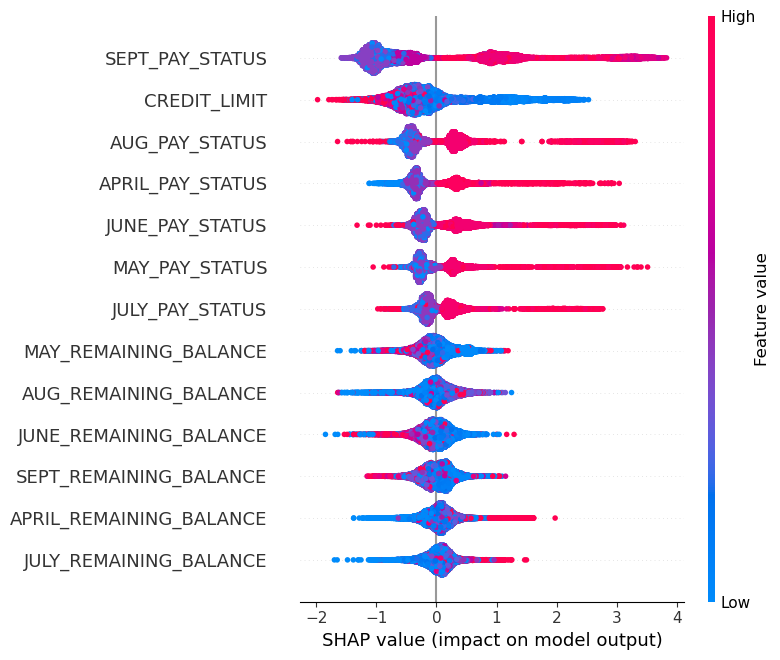

In [29]:
remaining_balance_model_shap = shap_summary(xgb_model_all_derived_features_no_demo, derived_features_train_resampled_no_demo)

### Credit util derived feature

In [36]:
derived_features = features.copy()

for month in months:
    derived_features['{}_CREDIT_UTIL'.format(month)] = derived_features['{}_BILL'.format(month)] / derived_features['CREDIT_LIMIT'.format(month)]

scaler = StandardScaler()
derived_features_scaled = scaler.fit_transform(derived_features)
derived_features_scaled =  pd.DataFrame(derived_features_scaled, columns=derived_features.columns, index=derived_features.index)

derived_features_train, derived_features_test, targets_train, targets_test = train_test_split(derived_features_scaled, targets, test_size=0.3, random_state=0)

derived_features_train_resampled, targets_train_resampled = kmeans_smote.fit_resample(derived_features_train, targets_train)

/Users/alejandromarchini/miniconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### xgboost with derived credit utilization feature

Accuracy score: 0.8111111111111111

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.88      7060
           1       0.59      0.40      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.72      0.66      0.68      9000
weighted avg       0.79      0.81      0.80      9000

ROC-AUC Score: 0.7578071610058118


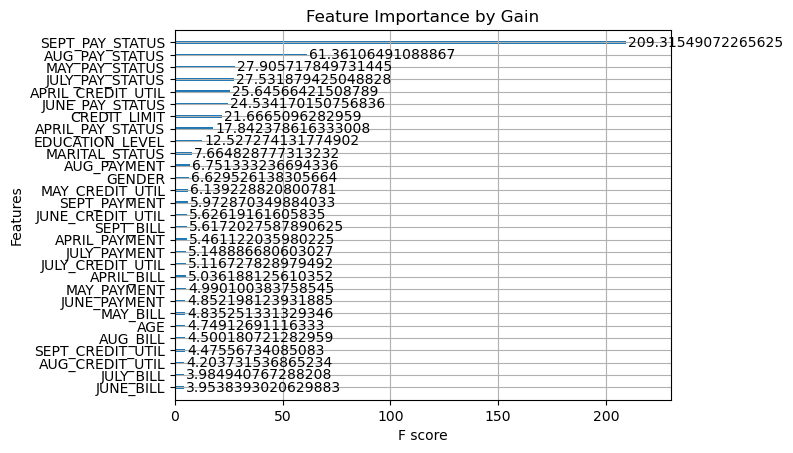

In [37]:
xgb_model_credit_util_feature = XGBClassifier(eval_metric='logloss')
xgb_model_credit_util_feature.fit(derived_features_train_resampled, targets_train_resampled)

xgb_predict_and_score(xgb_model_credit_util_feature, derived_features_test, targets_test)

Accuracy score: 0.8087777777777778

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      7060
           1       0.58      0.40      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.72      0.66      0.68      9000
weighted avg       0.79      0.81      0.79      9000

ROC-AUC Score: 0.7582776496013551


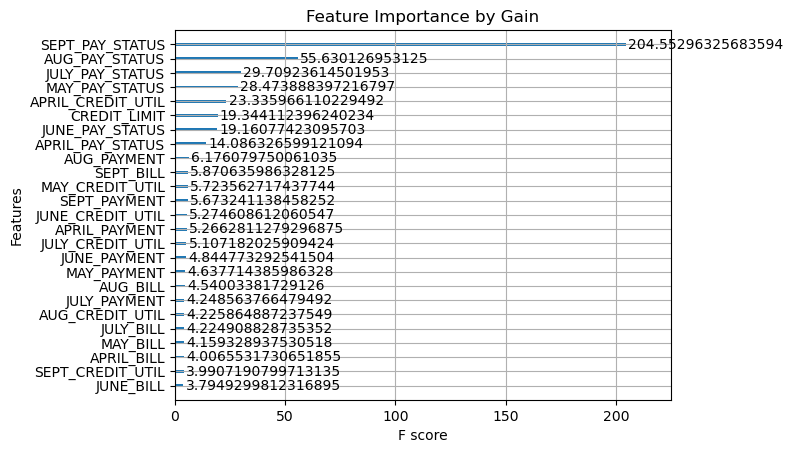

In [38]:
derived_features_train_resampled_no_demo = derived_features_train_resampled.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)
derived_features_test_no_demo = derived_features_test.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)

xgb_model_all_derived_features_no_demo = XGBClassifier(eval_metric='logloss')
xgb_model_all_derived_features_no_demo.fit(derived_features_train_resampled_no_demo, targets_train_resampled)

xgb_predict_and_score(xgb_model_all_derived_features_no_demo, derived_features_test_no_demo, targets_test)

 99%|===================| 32387/32612 [01:13<00:00]        

              Feature  SHAP Importance
1     SEPT_PAY_STATUS         1.315226
0        CREDIT_LIMIT         0.700694
6    APRIL_PAY_STATUS         0.279432
19  APRIL_CREDIT_UTIL         0.249205
2      AUG_PAY_STATUS         0.246184
3     JULY_PAY_STATUS         0.222020
13       SEPT_PAYMENT         0.204401
7           SEPT_BILL         0.201763
4     JUNE_PAY_STATUS         0.170868
18      APRIL_PAYMENT         0.170404
5      MAY_PAY_STATUS         0.168040
14        AUG_PAYMENT         0.158379
17        MAY_PAYMENT         0.147612
21   JUNE_CREDIT_UTIL         0.129550
15       JULY_PAYMENT         0.125086
23    AUG_CREDIT_UTIL         0.118990
10          JUNE_BILL         0.116496
22   JULY_CREDIT_UTIL         0.115090
11           MAY_BILL         0.103041
8            AUG_BILL         0.101956
16       JUNE_PAYMENT         0.095977
9           JULY_BILL         0.095910
20    MAY_CREDIT_UTIL         0.087789
24   SEPT_CREDIT_UTIL         0.086329
12         APRIL_BILL    

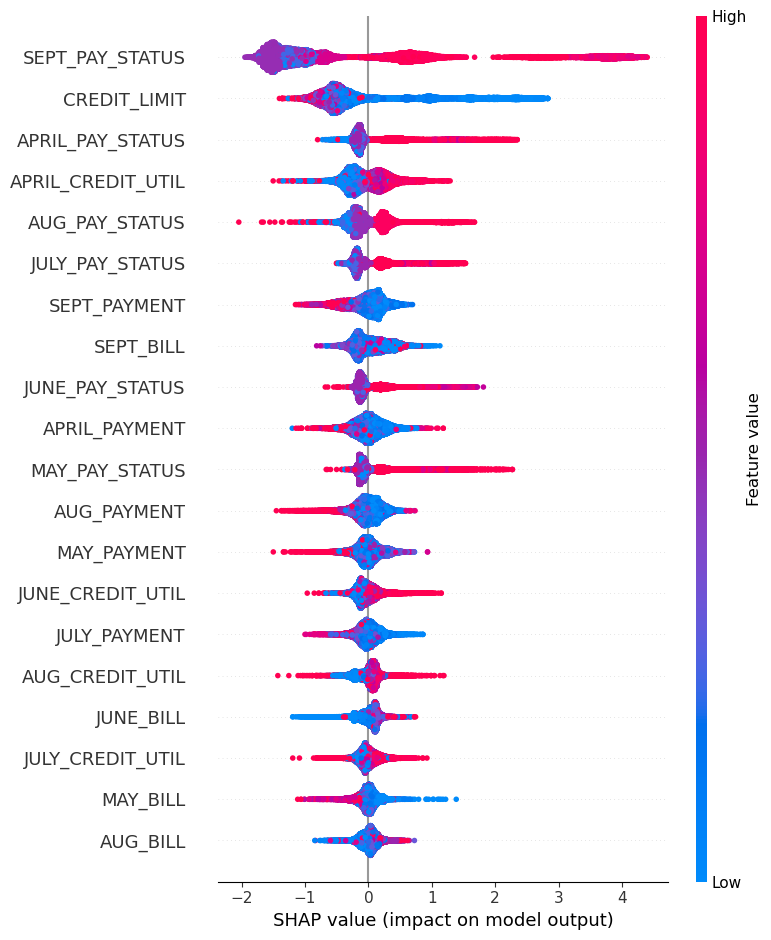

In [39]:
credit_util_model_shap = shap_summary(xgb_model_all_derived_features_no_demo, derived_features_train_resampled_no_demo)

In [41]:
credit_util_model_shap['cumulative_importance'] = credit_util_model_shap['SHAP Importance'].cumsum() / credit_util_model_shap['SHAP Importance'].sum()
no_demo_filtered_features = credit_util_model_shap[credit_util_model_shap['cumulative_importance'] <= 0.9]
no_demo_filtered_features

,Feature,SHAP Importance,cumulative_importance
1,SEPT_PAY_STATUS,1.315226,0.239600
0,CREDIT_LIMIT,0.700694,0.367248
6,APRIL_PAY_STATUS,0.279432,0.418153
19,APRIL_CREDIT_UTIL,0.249205,0.463552
2,AUG_PAY_STATUS,0.246184,0.508400
3,JULY_PAY_STATUS,0.222020,0.548846
13,SEPT_PAYMENT,0.204401,0.586083
7,SEPT_BILL,0.201763,0.622839
4,JUNE_PAY_STATUS,0.170868,0.653967
18,APRIL_PAYMENT,0.170404,0.685010


Accuracy score: 0.8117777777777778

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.60      0.39      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.72      0.66      0.68      9000
weighted avg       0.79      0.81      0.80      9000

ROC-AUC Score: 0.7592260009929618


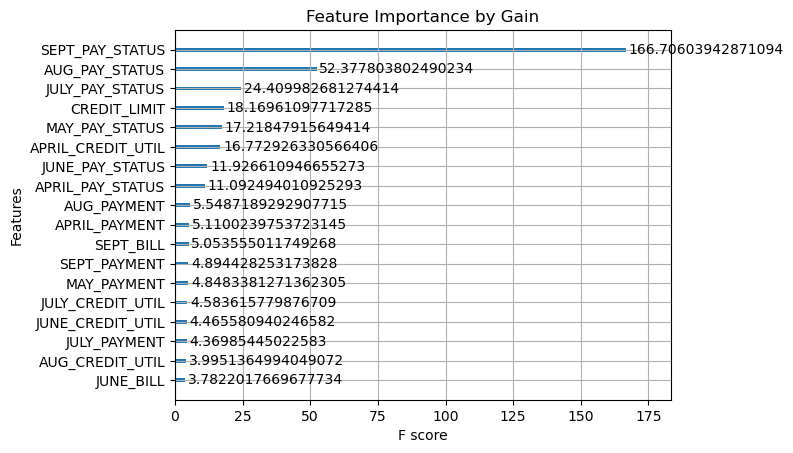

In [45]:
features_train_passing_shap_threshold_no_demo = derived_features_train_resampled_no_demo[no_demo_filtered_features['Feature'].tolist()]
features_test_passing_shap_threshold_no_demo = derived_features_test_no_demo[no_demo_filtered_features['Feature'].tolist()]

xgb_model_passing_shap_threshold_no_demo = XGBClassifier(eval_metric='logloss')
xgb_model_passing_shap_threshold_no_demo.fit(features_train_passing_shap_threshold_no_demo, targets_train_resampled)

xgb_predict_and_score(xgb_model_passing_shap_threshold_no_demo, features_test_passing_shap_threshold_no_demo, targets_test)

In [48]:
xgb_minimal = XGBClassifier(eval_metric='logloss')
xgb_minimal.fit(features_train_resampled[['SEPT_PAY_STATUS', 'AUG_PAY_STATUS']], targets_train_resampled)

xgb_predict_and_score(xgb_minimal, features_test[['SEPT_PAY_STATUS', 'AUG_PAY_STATUS']], targets_test)

ValueError: feature_names mismatch: ['CREDIT_LIMIT', 'GENDER', 'EDUCATION_LEVEL', 'MARITAL_STATUS', 'AGE', 'SEPT_PAY_STATUS', 'AUG_PAY_STATUS', 'JULY_PAY_STATUS', 'JUNE_PAY_STATUS', 'MAY_PAY_STATUS', 'APRIL_PAY_STATUS', 'SEPT_BILL', 'AUG_BILL', 'JULY_BILL', 'JUNE_BILL', 'MAY_BILL', 'APRIL_BILL', 'SEPT_PAYMENT', 'AUG_PAYMENT', 'JULY_PAYMENT', 'JUNE_PAYMENT', 'MAY_PAYMENT', 'APRIL_PAYMENT'] ['SEPT_PAY_STATUS', 'AUG_PAY_STATUS']
expected JUNE_PAYMENT, JULY_PAYMENT, APRIL_BILL, JUNE_PAY_STATUS, JUNE_BILL, MAY_PAY_STATUS, JULY_BILL, APRIL_PAYMENT, MARITAL_STATUS, EDUCATION_LEVEL, CREDIT_LIMIT, APRIL_PAY_STATUS, SEPT_BILL, AUG_PAYMENT, MAY_PAYMENT, AGE, AUG_BILL, GENDER, JULY_PAY_STATUS, SEPT_PAYMENT, MAY_BILL in input data